In [5]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 0. Чтение данных и преобработка ##

In [6]:
df = pd.read_csv('dating_data.csv')

In [10]:
# Проверка данных на наличие дубликатов

if (len(df.drop_duplicates())-len(df))== 0:
    print("В датафрейме отсутствуют дубликаты")
else:
    print("В датафрейме найдены дубликаты")

В датафрейме отсутствуют дубликаты


In [11]:
# Функция поиска пустых значений по столбцам датафрейма

def check_empty(df):
    empty_cols = []
    for col in df.columns:
        if df[col].isna().any():
            empty_cols.append(col)
    if empty_cols:
        return f"В столбце {', '.join(empty_cols)} найдены пустые значения."
    else:
        return "Пустые значения не найдены."

In [12]:
# Проведем проверку на пустоты с помощью написанной функции

print(check_empty(df))

Пустые значения не найдены.


In [13]:
# Проводим проверку типа данных

df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

## 1. Предварительное исследование данных ##

df - датафрейм с логами взаимодействия пользователей в приолжении онлайн-знакомств:

- user_id_1	- идентификатор пользователя 1
- user_id_2 - идентификатор пользователя 2
- group	- тестовая группа: 0 - контрольная группа, 1 - тестовая группа
- is_match - идентификатор взаимного лайка: 0 - нет взаимного лайка, 1 - лайки поставлены взаимно

Исследуем данные: посмотрим объем выборок, посмотрим активность 

In [15]:
df.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


Определим размер выборки в каждой из групп

In [20]:
# Размер выборки в контрольной группе

df.query('group == "0"').agg({'user_id_1':'nunique'})

user_id_1    501
dtype: int64

In [24]:
# Размер выборки в тестовой группе

df.query('group == "1"').agg({'user_id_1':'nunique'})

user_id_1    499
dtype: int64

Таким образом, размер выборки контрольной и тестовой группы различен, что, конечно, не соответствует правилам проведения АБ-тестирования (т.е. группы должны быть одинакого размера - в идеальной картине мира), разница в объеме выборки - 2 пользователя, поэтому считаем её несущественной.

Проверим однородность групп в пределах наших данных. Исследуем активность пользователей в рамках теста.

In [30]:
# Посчитаем количество наблюдений по каждому пользователю

df.user_id_1.value_counts()

170    29
38     28
827    28
198    27
819    26
       ..
129     3
661     3
30      2
904     2
436     1
Name: user_id_1, Length: 1000, dtype: int64

Таким образом, мы видим, что некоторые пользователи были более активны за период проведения тестирования, чем другие. 

Если система сплитования работает исправно, то это не помешает качественному анализу результатов тестирования, поскольку на активность пользователей как раз могла повлиять работа нового алгоритма

Рассмотрим к какой группе относятся активные пользователи в большинстве

In [32]:
# Проверим активность пользователей контрольной группы

df.query('group == "0"') \
  .groupby('user_id_1', as_index=False) \
  .agg({'user_id_2':'count'}) \
  .sort_values('user_id_2', ascending=False)

,user_id_1,user_id_2
4,15,20
389,768,18
240,476,18
493,989,17
25,51,17
...,...,...
457,921,3
466,943,3
12,30,2
450,904,2


In [33]:
# Проверим активность пользователей тестовой группы

df.query('group == "1"') \
  .groupby('user_id_1', as_index=False) \
  .agg({'user_id_2':'count'}) \
  .sort_values('user_id_2', ascending=False)

,user_id_1,user_id_2
82,170,29
21,38,28
407,827,28
99,198,27
404,819,26
...,...,...
189,380,12
320,649,12
365,744,12
35,79,11


На первый взгляд тестовая группа активнее, чем контрольная

Исследуем также количество мэтчей в контрольной и тестовой группе

In [34]:
# Проверим количество мэтчей пользователей контрольной группы

df.query('group == "0" and is_match== "1"') \
  .groupby('user_id_1', as_index=False) \
  .agg({'is_match':'count'}) \
  .sort_values('is_match', ascending=False)

,user_id_1,is_match
309,714,9
55,128,6
78,197,6
235,558,6
266,628,6
...,...,...
303,705,1
304,706,1
137,348,1
135,338,1


In [35]:
# Проверим количество мэтчей пользователей контрольной группы

df.query('group == "1" and is_match== "1"') \
  .groupby('user_id_1', as_index=False) \
  .agg({'is_match':'count'}) \
  .sort_values('is_match', ascending=False)

,user_id_1,is_match
18,32,16
406,827,15
82,170,15
88,177,15
339,691,14
...,...,...
172,339,3
184,364,3
444,882,2
433,865,2


Таким образом, мэтчи в контрольной группы 84 % пользователей, а в тестовой группе - 99.8 % пользователей (т.е. все, кроме одного пользователя хотя бы один раз получили взаимный мэтч)

## 2. Анализ результатов АБ-тестирования

### 1. Гипотеза тестирования

Первичная гипотеза: новый алгоритм улучшил качество сервиса

### 2. Выбор метрики

Сервис нашего приложения состоит в помощи поиска парнера/друга и т.д. Т.е. результат, который пользователь хочет получить - новое знакомство. Поскольку знакомство может начаться только после проявления взаимной симпатии - мэтча, в качестве метрик качества сервиса будем использовать:

- доля мэтчей от общего количества сгенерированных пар (share of matches - SM)
- среднее количество мэтчей на каждого пользователя (average matches - AM)

Мы считаем, что качество сервиса улучшилось, если

- доля мэтчей от общего количества сгенерированных пар (share of matches - SM) - выросла хотя бы на 15 %
- среднее количество мэтчей на одного пользователя (average matches - AM) - увеличилось на 4 мэтча

#### 1) Share of matches - SM

In [41]:
# Считаем количество пар по группам

SM_all = df.groupby("group", as_index=False) \
           .agg({'user_id_1':'count'}) \
           .rename(columns={"user_id_1" : "all"})

In [42]:
# Считаем количество мэтчей по группам

SM = df.query("is_match == 1") \
       .groupby("group", as_index=False) \
       .agg({'is_match':'count'})

In [43]:
# Объединяем данные в одну таблицу

SM = SM.merge(SM_all, on="group")

In [50]:
# Рассчитываем метрику - SM

SM['SM'] = SM['is_match'] / SM['all'] * 100
SM

,group,is_match,all,SM
0,0,934,4792,19.490818
1,1,3909,9722,40.207776


Таким образом, доля мэтчей от общего количества сгенерированных пар возросла на 20 %. Используем эти данные в дальнейшем для определения уровня статистической значимости этого изменения.

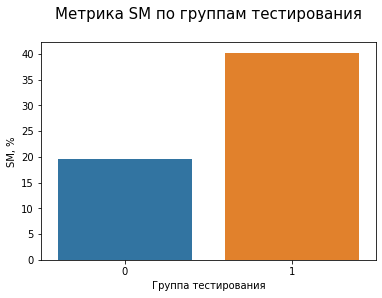

In [56]:
# Построим график

ax = sns.barplot(data=SM, y='SM', x='group')
ax.set_ylabel('SM, %')
ax.set_xlabel('Группа тестирования')
ax.set_title('Метрика SM по группам тестирования\n', fontsize=15)
plt.show()

#### 2) Average matches - AM

In [57]:
# Рассчитаем количество мэтчей для одного пользователя в каждой группе

AM = df.groupby(["user_id_1", "group"], as_index=False) \
       .agg({'is_match':'count'})
AM

,user_id_1,group,is_match
0,1,1,24
1,2,1,16
2,3,1,16
3,4,0,9
4,5,1,22
...,...,...,...
995,996,0,8
996,997,0,12
997,998,1,18
998,999,0,7


In [58]:
# Рассчитаем среднее количество мэтчей на пользователя для каждой группы

AM.groupby('group', as_index=False) \
  .agg({'is_match':'mean'}) \
  .rename(columns={'is_match':'AM'})

,group,AM
0,0,9.564870
1,1,19.482966


По результатам расчета метрики AM наблюдаем рост среднего количества мэтчей на пользователя на 10 мэтчей. Это наблюдение соответствует нашему определению "улучшения качества сервиса", однако необходимо проверить статистическую значимость таких результатов.

### 3. Проверка статистической значимости наблюдений

#### 1) Share of matches - SM

Для рассчета метрики SM рассчитываются категориальные переменные (т.е. получил мэтч/не получил мэтч), таким образом, для проверки статистической значимости результатов воспользуемся хи-квадратом

Гипотезы:
- H0 - статистически значимая разница между ожидаемыми и наблюдаемыми частотами переменной 'is_match' отсутствует
- H1 - разница между ожидаемыми и наблюдаемыми частотами переменной 'is_match' статистически значима

In [60]:
expected, observed, stats = pg.chi2_independence(df, x='group', y='is_match')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


Поскольку p-value < 0.05, отклоняем нулевую гипотезу об отсуствии статистически значимой разницы между ожидаемыми и наблюдаемыми частотами переменной 'is_match'

#### 2)  Average matches - AM

Для рассчета метрики AM рассчитываются количественные переменные (т.е. количество мэтчей), таким образом, для проверки статистической значимости результатов проведем проверку данных на гомоскедастичность, а распределение проверим на нормальность

In [61]:
# Проверка данных на гомоскедастичность

pg.homoscedasticity(data=AM, dv='is_match', group='group')

,W,pval,equal_var
levene,0.480454,0.488378,True


In [62]:
# Проверка на нормальность распределения

pg.normality(data=AM, dv='is_match', group='group', method = 'normaltest')

,W,pval,normal
1,4.262189,0.118707,True
0,2.406168,0.300267,True


Поскольку данные обладают гомоскедастичностью и распределены нормально, для проверки на статистическую значимость проведем дисперсионный анализ (ANOVA)

Гипотезы:
- H0 - статистически значимая разница между средними значениями отсутствует
- H1 - разница между средними значениями статистически значима

In [64]:
AM.anova(dv='is_match', between=['group']).round(3)

,Source,ddof1,ddof2,F,p-unc,np2
0,group,1,998,2688.82,0.0,0.729


Поскольку p-value меньше 0.05, нулевая гипотеза отклонена, а значит разница между средним количеством мэтчей статистически значима

### 4. Вывод

Таким образом, принимаем первичную гипотезу тестирования: новый алгоритм поиска пар улучшил качество сервиса.

С точки зрения аналитики: новый алгоритм доазал свою эффективность на двух метриках, поскольку эти метрики выбраны как основные для оценки качества сервиса, можно сказать, что новый алгоритм можно выкатить в прод.

С точки зрения бизнеса: дейтинговые сервисы зарабатывают, в основном, на удержании пользователей всервисе (Revenue rate), продаже доп.услуг и показах рекламы. В нашем случае при использовании нового алгоритма поиска Revenue rate будет снижаться (т.к. пользователи перестанут пользоваться сервисом, как только найдут друга/партнера). Возможно, конечно, это привлечет новых пользователей (сарафанное радио об удачных историях знакомства), но для оценки финансовой эффективности этого решения необходимо рассчитать потенциальные затраты и выручку.